In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

# creating a numpy random number generator for sampling
#rng = np.random.default_rng(seed=42)
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = 512 # I did nside=256 as well and got similar results.
lmax = 256

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 150 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, 0.0, 1.0, dx=150.0) # shells set to 150Mpc spacing

# linear radial window functions
ws = glass.linear_windows(zb)

cls = glass.ext.camb.matter_cls(pars, lmax, ws)#np.load('cls2_n256_l256_150x5.npy')

In [2]:
disc_cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=5) # correlations of 5 shells


# localised redshift distribution
# the actual density per arcmin2 does not matter here, it is never used
z = np.linspace(0.0, 1.0, 101)
dndz = np.exp(-((z - 0.5) ** 2) / (0.1) ** 2)

# distribute dN/dz over the radial window functions
ngal = glass.partition(z, dndz, ws)

In [3]:
scls = []
for i in range(10):
    # this will compute the convergence field iteratively
    convergence = glass.MultiPlaneConvergence(cosmo)
    # compute Gaussian spectra for lognormal fields from discretised spectra
    gls = glass.lognormal_gls(disc_cls)
    matter = glass.generate_lognormal(gls, nside, ncorr=5)#, rng=rng) # continuing to correlate 5 shells

    # the integrated convergence and shear field over the redshift distribution
    kappa_bar = np.zeros(12 * nside**2)
    gamm1_bar = np.zeros(12 * nside**2)
    gamm2_bar = np.zeros(12 * nside**2)

    # main loop to simulate the matter fields iterative
    for i, delta_i in enumerate(matter):
        # add lensing plane from the window function of this shell
        convergence.add_window(delta_i, ws[i])

        # get convergence field
        kappa_i = convergence.kappa

        # compute shear field
        gamm1_i, gamm2_i = glass.shear_from_convergence(kappa_i)

        # add to mean fields using the galaxy number density as weight
        kappa_bar += ngal[i] * kappa_i
        gamm1_bar += ngal[i] * gamm1_i
        gamm2_bar += ngal[i] * gamm2_i

    # normalise mean fields by the total galaxy number density
    kappa_bar /= ngal.sum()
    gamm1_bar /= ngal.sum()
    gamm2_bar /= ngal.sum()
    # get the angular power spectra of the lensing maps
    sim_cls = hp.anafast(
        [kappa_bar, gamm1_bar, gamm2_bar],
        pol=True,
        lmax=lmax,
        use_pixel_weights=True,
    )
    scls.append(sim_cls[0])

In [4]:
sim_final = np.array(scls)
sim_avg = sim_final.mean(axis=0)

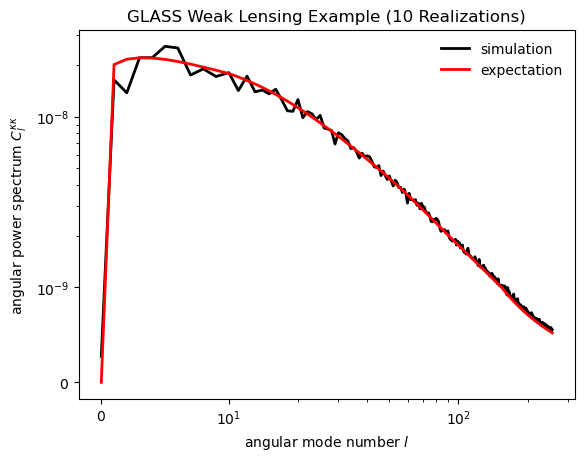

In [5]:
# get the expected cls from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type="lensing"),
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

# get the HEALPix pixel window function, since the lensing fields have it
pw = hp.pixwin(nside, lmax=lmax)

# plot the realised and expected cls
ell = np.arange(lmax + 1)
plt.title("GLASS Weak Lensing Example (10 Realizations)")

plt.plot(ell, sim_avg, "-k", lw=2, label="simulation")
plt.plot(ell, theory_cls["W1xW1"] * pw**2, "-r", lw=2, label="expectation")
plt.xscale("symlog", linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale("symlog", linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r"angular mode number $l$")
plt.ylabel(r"angular power spectrum $C_l^{\kappa\kappa}$")
plt.legend(frameon=False)
plt.show()

/scratch/local/jobs/28537176/ipykernel_1800952/1975051756.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(ell, (sim_avg - theory)/theory, "-k", lw=2, label="simulation")


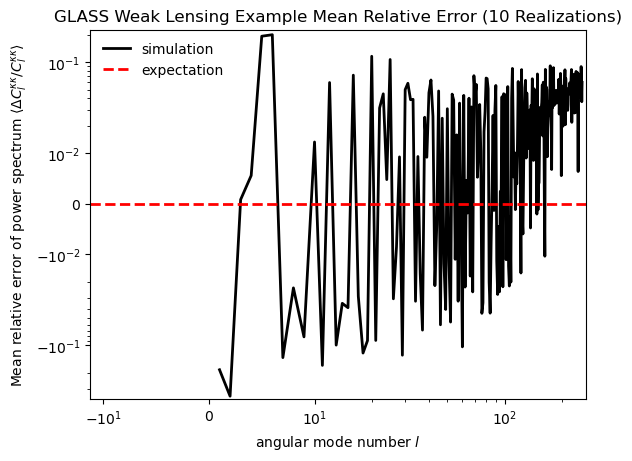

In [6]:
theory = theory_cls["W1xW1"] * pw**2
plt.title("GLASS Weak Lensing Example Mean Relative Error (10 Realizations)")
plt.plot(ell, (sim_avg - theory)/theory, "-k", lw=2, label="simulation")
plt.axhline(0, ls="--", lw=2, label="expectation", color = 'red')
plt.xscale("symlog", linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale("symlog", linthresh=1e-2, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r"angular mode number $l$")
plt.ylabel(r"Mean relative error of power spectrum $\langle \Delta C_l^{\kappa\kappa} / C_l^{\kappa\kappa} \rangle$")
plt.legend(frameon=False)
plt.show()